# Gaussian Mixture Classification as Regression

In this Notebook, we consider the [GMM dataset](https://git.ee.ethz.ch/henningc/hypnettorch/-/blob/master/hypnettorch/data/special/gmm_data.py) as a regression problem with in-distribution function values $-1$ (negative class) and $+1$ (positive class).

Specifically, we consider a Gaussian likelihood, such that we can analytically compute the posterior predictive when performing Gaussian Process regression.

In [1]:
#import gpytorch
from argparse import Namespace
from datetime import datetime
from hypnettorch.data.special.gaussian_mixture_data import get_gmm_tasks
from hypnettorch.data.special.gmm_data import GMMData
from hypnettorch.utils.sim_utils import setup_environment
from hypnettorch.utils import misc
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, ExpSineSquared, RationalQuadratic
import sys
from time import time
import torch
import tqdm
import traceback

# Pretend that notebook is located in base directory of this repo.
curr_dir = os.path.basename(os.path.abspath(os.curdir))
base_dir = os.path.abspath('../..')
if curr_dir == 'nngp' and base_dir != sys.path[0]:
    sys.path.insert(0, base_dir)

from data.gmm_utils import get_circle_gmm_instance
from nngp.nngp import inference_with_isotropic_gaussian_ll, gen_inference_kernels, cholesky_adaptive_noise
from nngp import MLPKernel #, RBFNetKernel 
from nngp.rbf_net import RBFNetKernel
from utils import notebook as nutils
from utils.plotting import heatmap
from utils.misc import eval_grid_2d, calc_regression_acc


from IPython.display import display, Markdown, Latex
#display(Markdown('*some markdown* $\phi$'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Create output directory and other helpers.
config = Namespace()
config.out_dir = './out/gmm_kernels/run_' + \
    datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
config.loglevel_info = False
config.random_seed = 42
config.use_cuda = False # CPU usually faster for simple problems.
config.deterministic_run = True
# Delete file from previous tutorial session:
if os.path.exists(config.out_dir):
    shutil.rmtree(config.out_dir)
device, writer, logger = setup_environment(config, logger_name='hmc_finite_logger')

Created output folder ./out/gmm_kernels/run_2021-10-03_15-08-12.
10/03/2021 03:08:12 PM - INFO - Using cuda: False


In [2]:
likelihood_var = 2e-2

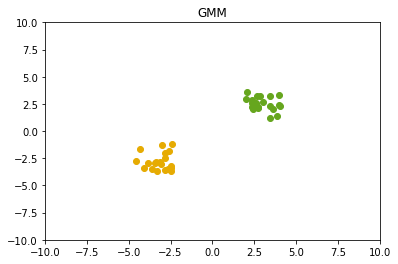

In [3]:
if False:
    means = [np.array([-2, -2]), np.array([2, 2])]
    covs = [1 * np.eye(len(mean)) for mean in means]
    modes = get_gmm_tasks(means=means, covs=covs, num_train=10,
                          num_test=100)
    data = GMMData(modes, classification=True, use_one_hot=False)
else:
    data = get_circle_gmm_instance(sigmas=[.5]*2, num_train=20,
                                   num_test=100, use_one_hot=False,
                                   radius=4, offset=-np.pi/4,
                                   rseed=1)

X = data.get_train_inputs()
Y = data.get_train_outputs().squeeze()

colors = misc.get_colorbrewer2_colors(family='Dark2')

plt.title('GMM')
plt.scatter(X[Y==0,0], X[Y==0,1], c=colors[4])
plt.scatter(X[Y==1,0], X[Y==1,1], c=colors[5])
plt.ylim(-10, 10)
plt.xlim(-10, 10)
plt.show()

# We use symmetrical values -1 / 1 for classification
Y[Y==0] = -1

### Specifying grid in input space for plotting kernel properties.

In [4]:
grid_X1, grid_X2, grid_X = eval_grid_2d(x_range=(-10, 10), y_range=(-10, 10), res_per_unit=10,
                                        verbose=True)

# Translate grid to PyTorch tensor.
X_train = torch.from_numpy(X.astype(np.float32)).to(device)
Y_train = torch.from_numpy(Y.astype(np.float32)).to(device)
X_test = torch.from_numpy(grid_X.astype(np.float32)).to(device)

heatmap_kwargs = {
    'grid_X': grid_X1,
    'grid_Y': grid_X2,
    'show_title': False,
    'num_levels': 100,
    'log_levels': False,
    'crop': False,
    'xticks': [-8, -4, 0, 4, 8],
    'yticks': [-8, -4, 0, 4, 8],
    'data_in': X,
    'data_trgt': Y,
    'out_dir': config.out_dir,
    'ts': 30,
    'lw': 15, 
    'figsize': (12, 7)
}

Grid resolution: 200 x 200.


# Gaussian Process Regression with Sklearn.

**Length-scale** 1.000000

train  (40, 2) mean -1.017030291320554 1.0174273377309124 std 0.06724694762437422 0.1384216688974198
grid  (40000, 2) mean -1.0351167129184216 1.0465655643629757 std 0.06193774996952325 1.0
Accuracy on training points: 100.00%


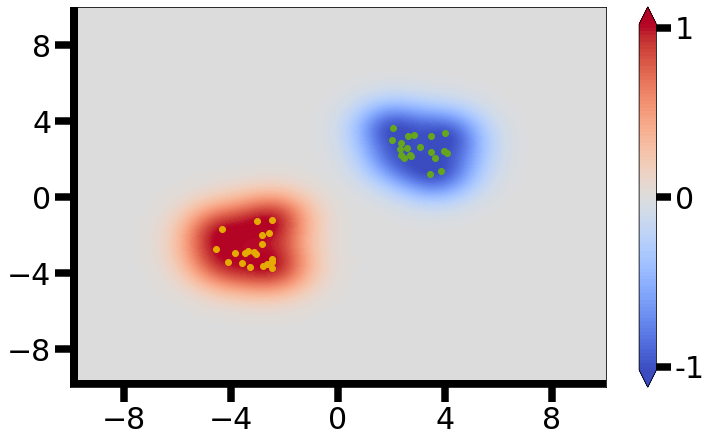

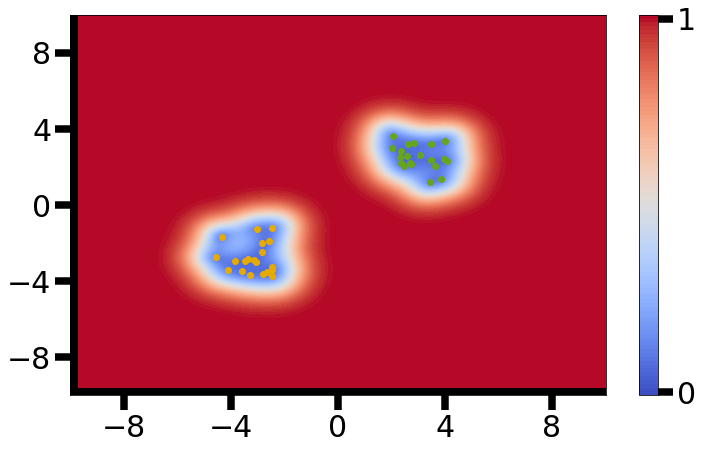

In [5]:
length_scale = [.5, 1, 2]
length_scale = [1]

for i, ls in enumerate(length_scale):
    display(Markdown('**Length-scale** %f' % (ls)))
    rbf_kernel = RBF(length_scale=ls, length_scale_bounds="fixed")
    K_rbf = rbf_kernel(X)
    gpr = GaussianProcessRegressor(kernel=rbf_kernel, alpha=likelihood_var, 
                                   random_state=42).fit(X, Y)

    rbf_train_mean, rbf_train_std = gpr.predict(X, return_std=True)
    print('train ', X.shape, 'mean', rbf_train_mean.min(), rbf_train_mean.max(), 
          'std', rbf_train_std.min(), rbf_train_std.max())

    rbf_grid_mean, rbf_grid_std = gpr.predict(grid_X, return_std=True)
    print('grid ', grid_X.shape, 'mean', rbf_grid_mean.min(), rbf_grid_mean.max(),
          'std', rbf_grid_std.min(), rbf_grid_std.max())

    print('Accuracy on training points: %.2f%%' % \
          calc_regression_acc(torch.from_numpy(rbf_train_mean).to(device), Y_train))

    #heatmap(rbf_grid_mean, title='Posterior Predictive Mean - RBF %.2f' % (ls),
    #        **heatmap_kwargs)
    
    heatmap(rbf_grid_mean, title='Posterior Predictive Mean - RBF %.2f' % (ls),
            vmin=-1, vmax=1, force_extend=None, cticks=[-.98, 0, .98], ctick_lbls=['-1', '0', '1'],
            filename='post_mean_rbf', **heatmap_kwargs)
    
    heatmap(rbf_grid_std, title='Posterior Predictive Std - RBF %.2f' % (ls),
            vmin=0, vmax=1, force_extend=None, cticks=[.0075, 0.99], ctick_lbls=['0', '1'],
            filename='post_std_rbf', **heatmap_kwargs)

train  (40, 2) mean -1.289004778811318 1.2485443999623271 std 0.028846489790324573 0.05946134791790909
grid  (40000, 2) mean -3.407827922313004 3.3390206776088007 std 0.022376288346468508 0.4361783052256
Accuracy on training points: 100.00%


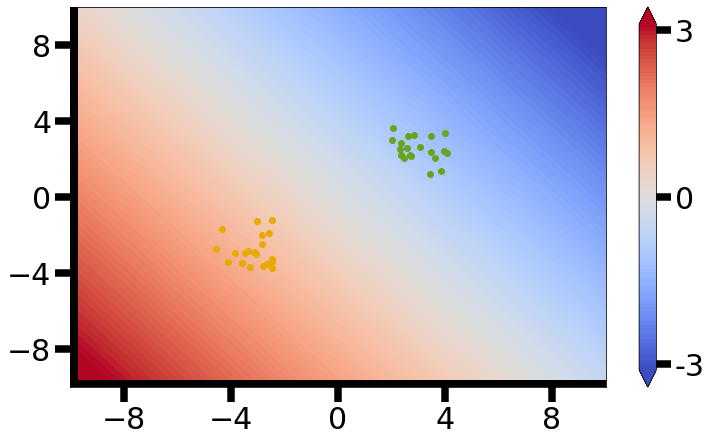

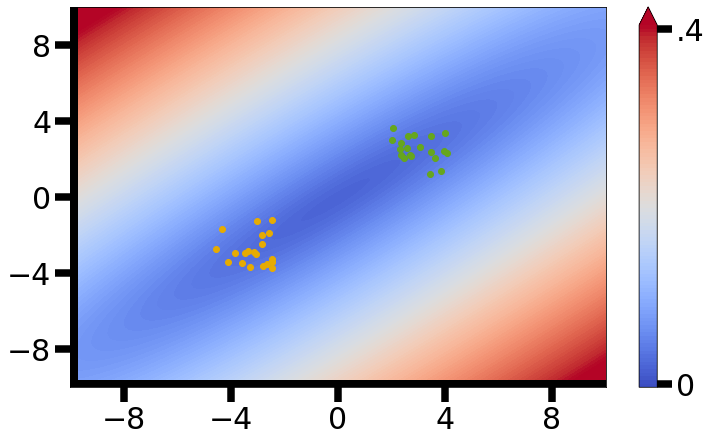

In [6]:
dot_kernel = DotProduct(sigma_0=1, sigma_0_bounds="fixed")
K_dot = dot_kernel(X)
gpr = GaussianProcessRegressor(kernel=dot_kernel, alpha=likelihood_var, 
                               random_state=42).fit(X, Y)

train_mean, train_std = gpr.predict(X, return_std=True)
print('train ', X.shape, 'mean', train_mean.min(), train_mean.max(), 
      'std', train_std.min(), train_std.max())

grid_mean, grid_std = gpr.predict(grid_X, return_std=True)
print('grid ', grid_X.shape, 'mean', grid_mean.min(), grid_mean.max(),
      'std', grid_std.min(), grid_std.max())

print('Accuracy on training points: %.2f%%' % \
      calc_regression_acc(torch.from_numpy(train_mean).to(device), Y_train))

heatmap(grid_mean, title='Posterior Predictive Mean - DotProduct',
        vmin=-3, vmax=3, force_extend='both', cticks=[-2.9, 0, 2.9],
        ctick_lbls=['-3', '0', '3'], filename='post_mean_dot_product',
        **heatmap_kwargs)

heatmap(grid_std, title='Posterior Predictive Std - DotProduct',
        vmin=0, vmax=.4, force_extend='max', cticks=[0.004, .395], ctick_lbls=['0', '.4'],
        filename='post_std_dot_product',
        **heatmap_kwargs)

train  (40, 2) mean -1.0161814311797661 1.0153205787834487 std 0.06367217538353839 0.13682445051002554
grid  (40000, 2) mean -1.8591257776026304 1.7879411084292345 std 0.0 0.9999990738280543
Accuracy on training points: 100.00%


/home/christian/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:372: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


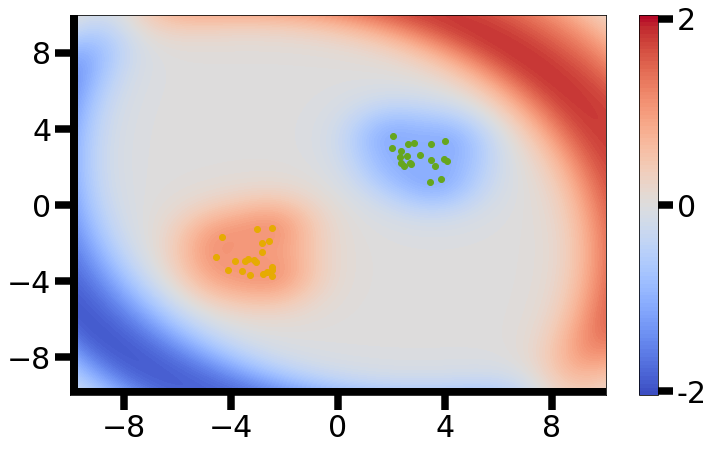

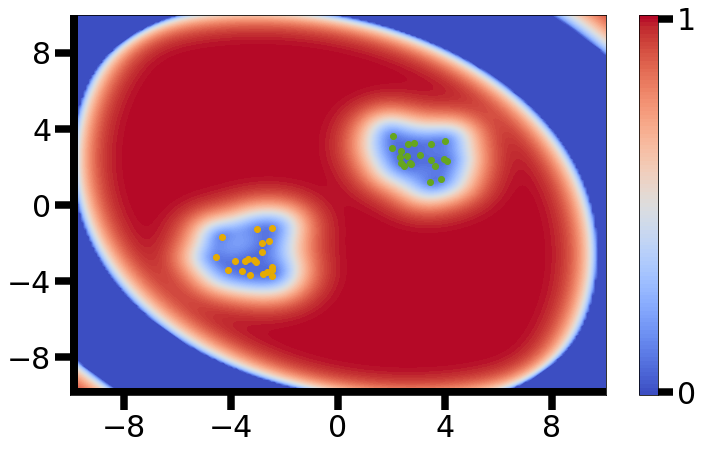

In [7]:
other_kernel = ExpSineSquared(length_scale=.5, periodicity=15,
                              length_scale_bounds='fixed',
                              periodicity_bounds='fixed')
#other_kernel = RationalQuadratic()
K_other = other_kernel(X)
gpr = GaussianProcessRegressor(kernel=other_kernel, alpha=likelihood_var, 
                               random_state=42).fit(X, Y)

train_mean, train_std = gpr.predict(X, return_std=True)
print('train ', X.shape, 'mean', train_mean.min(), train_mean.max(), 
      'std', train_std.min(), train_std.max())

grid_mean, grid_std = gpr.predict(grid_X, return_std=True)
print('grid ', grid_X.shape, 'mean', grid_mean.min(), grid_mean.max(),
      'std', grid_std.min(), grid_std.max())

print('Accuracy on training points: %.2f%%' % \
      calc_regression_acc(torch.from_numpy(train_mean).to(device), Y_train))

heatmap(grid_mean, title='Posterior Predictive Mean - ExpSineSquared',
        vmin=-2, vmax=2, force_extend=None, cticks=[-1.96, 0, 1.96], 
        ctick_lbls=['-2', '0', '2'], filename='post_mean_expsinesq',
        **heatmap_kwargs)

heatmap(grid_std, title='Posterior Predictive Std - ExpSineSquared',
        vmin=0, vmax=1, force_extend=None, cticks=[.0075, 0.99], ctick_lbls=['0', '1'],
        filename='post_std_expsinesq',
        **heatmap_kwargs)

# Neural Network Gaussian Process Regression

### Kernel of infinite-width RBF network

In [8]:
rbfnet_kernel_properties = [
    ### Relu - Analytic ###
    {'name': 'rbf_net', 'type': 'analytic',
     'params': {'n_lin_hidden_units': [], 'bandwidth': 1,
                'sigma2_u': 100, 'sigma2_w': 200., 'sigma2_b': 1},
     'kernel_params': {}},
]

In [9]:
%%script false --no-raise-error # Do not execute cell.

nutils.compute_kernel_values(rbfnet_kernel_properties, X_test, X_train, Y_train,
                             nutils.determine_rbf_net_kernel_func, test_bs=50,
                             out_dir=config.out_dir, try_inference=True,
                             heatmap_kwargs=heatmap_kwargs)

In [10]:
nutils.load_kernel_values(rbfnet_kernel_properties,
                          out_dir='./out/gmm_kernels/all_kernels', device=device)

Loading kernel for **rbf_net** ...

Working on **rbf_net** ...

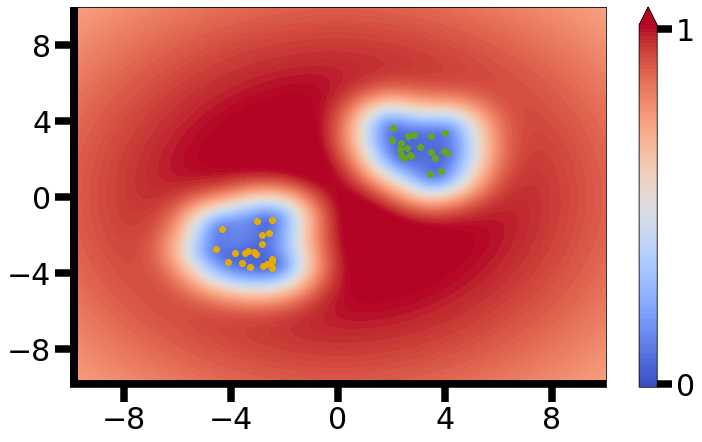

In [11]:
for i, k_props in enumerate(rbfnet_kernel_properties):    
    display(Markdown('Working on **%s** ...' % (k_props['name']))) 
    
    if 'K_train' not in k_props.keys():
        continue
    
    K_train = k_props['K_train']
    K_test = k_props['K_test']
    K_all = k_props['K_all']
    
    grid_mean, grid_var = inference_with_isotropic_gaussian_ll(Y_train, K_train,
        K_test, K_all, var=likelihood_var)
    
    grid_std = torch.sqrt(grid_var.cpu())

    heatmap(grid_std, title='Posterior Predictive Std - %s' % (k_props['name']),
        vmin=0, vmax=1, force_extend=None, cticks=[.01, 0.9875], ctick_lbls=['0', '1'],
        filename='post_std_%s' % k_props['name'],
        **heatmap_kwargs)

### Kernel of infinite-width MLP network

In [12]:
## Define MLP architectures to be considered
num_mc = 100000

nngp_kernel_properties = [
    ### Relu - Analytic ###
    {'name': 'ana_relu_1l', 'type': 'analytic',
     'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU(), 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    {'name': 'ana_relu_2l', 'type': 'analytic',
     'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU(), 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    {'name': 'ana_relu_4l', 'type': 'analytic',
     'params': {'n_layer': 4, 'nonlinearity': torch.nn.ReLU(), 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    {'name': 'ana_relu_8l', 'type': 'analytic',
     'params': {'n_layer': 8, 'nonlinearity': torch.nn.ReLU(), 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    ### Error Function - Analytic ###
    {'name': 'ana_erf_1l', 'type': 'analytic',
     'params': {'n_layer': 1, 'nonlinearity': torch.erf, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    {'name': 'ana_erf_2l', 'type': 'analytic',
     'params': {'n_layer': 2, 'nonlinearity': torch.erf, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    {'name': 'ana_erf_4l', 'type': 'analytic',
     'params': {'n_layer': 4, 'nonlinearity': torch.erf, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    {'name': 'ana_erf_8l', 'type': 'analytic',
     'params': {'n_layer': 8, 'nonlinearity': torch.erf, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    ### Relu ###
    {'name': 'relu_1l', 'type': 'mc',
     'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU(), 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {'num_samples': num_mc}},
    {'name': 'relu_2l', 'type': 'mc',
     'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU(), 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {'num_samples': num_mc}},
    #{'name': 'relu_4l', 'type': 'mc',
    # 'params': {'n_layer': 4, 'nonlinearity': torch.nn.ReLU(), 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    #{'name': 'relu_8l', 'type': 'mc',
    # 'params': {'n_layer': 8, 'nonlinearity': torch.nn.ReLU(), 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    ### Error Function ###
    {'name': 'erf_1l', 'type': 'mc',
     'params': {'n_layer': 1, 'nonlinearity': torch.erf, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {'num_samples': num_mc}},
    {'name': 'erf_2l', 'type': 'mc',
     'params': {'n_layer': 2, 'nonlinearity': torch.erf, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {'num_samples': num_mc}},
    ### Sigmoid ###
    {'name': 'sigmoid_1l', 'type': 'mc',
     'params': {'n_layer': 1, 'nonlinearity': torch.nn.Sigmoid(), 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {'num_samples': num_mc}},
    {'name': 'sigmoid_2l', 'type': 'mc',
     'params': {'n_layer': 2, 'nonlinearity': torch.nn.Sigmoid(), 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {'num_samples': num_mc}},
    #{'name': 'sigmoid_4l', 'type': 'mc',
    # 'params': {'n_layer': 4, 'nonlinearity': torch.nn.Sigmoid(), 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    #{'name': 'sigmoid_8l', 'type': 'mc',
    # 'params': {'n_layer': 8, 'nonlinearity': torch.nn.Sigmoid(), 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    ### Tanh ###
    {'name': 'tanh_1l', 'type': 'mc',
     'params': {'n_layer': 1, 'nonlinearity': torch.nn.Tanh(), 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {'num_samples': num_mc}},
    {'name': 'tanh_2l', 'type': 'mc',
     'params': {'n_layer': 2, 'nonlinearity': torch.nn.Tanh(), 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {'num_samples': num_mc}},
    #{'name': 'tanh_4l', 'type': 'mc',
    # 'params': {'n_layer': 4, 'nonlinearity': torch.nn.Tanh(), 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    #{'name': 'tanh_8l', 'type': 'mc',
    # 'params': {'n_layer': 8, 'nonlinearity': torch.nn.Tanh(), 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    ### Cosine - Analytic ###
    {'name': 'ana_cos_1l', 'type': 'analytic',
     'params': {'n_layer': 1, 'nonlinearity': torch.cos, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    ### Cosine ###
    #{'name': 'cos_1l', 'type': 'mc',
    # 'params': {'n_layer': 1, 'nonlinearity': torch.cos, 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    #{'name': 'cos_2l', 'type': 'mc',
    # 'params': {'n_layer': 2, 'nonlinearity': torch.cos, 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    #{'name': 'cos_3l', 'type': 'mc',
    # 'params': {'n_layer': 3, 'nonlinearity': torch.cos, 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
]

In [13]:
%%script false --no-raise-error # Do not execute cell.

nutils.compute_kernel_values(nngp_kernel_properties, X_test, X_train, Y_train,
                             nutils.determine_mlp_kernel_func, test_bs=50,
                             out_dir=config.out_dir, try_inference=True,
                             heatmap_kwargs=heatmap_kwargs)

In [14]:
#%%script false --no-raise-error # Do not execute cell.

nutils.load_kernel_values(nngp_kernel_properties,
                          out_dir='./out/gmm_kernels/all_kernels', device=device)

Loading kernel for **ana_relu_1l** ...

Loading kernel for **ana_relu_2l** ...

Loading kernel for **ana_relu_4l** ...

Loading kernel for **ana_relu_8l** ...

Loading kernel for **ana_erf_1l** ...

Loading kernel for **ana_erf_2l** ...

Loading kernel for **ana_erf_4l** ...

Loading kernel for **ana_erf_8l** ...

Loading kernel for **relu_1l** ...

Loading kernel for **relu_2l** ...

Loading kernel for **erf_1l** ...

Loading kernel for **erf_2l** ...

Loading kernel for **sigmoid_1l** ...

Loading kernel for **sigmoid_2l** ...

Loading kernel for **tanh_1l** ...

Loading kernel for **tanh_2l** ...

Loading kernel for **ana_cos_1l** ...

# What is the MC error for the ReLU case?

In [15]:
%%script false --no-raise-error # Do not execute cell.

for i, k_props in enumerate(nngp_kernel_properties):
    name1 = nngp_kernel_properties[i]['name']
    
    if not name1.startswith('ana_'):
        continue

    j = None
    for jj, k_props in enumerate(nngp_kernel_properties):
        name2 = nngp_kernel_properties[jj]['name']

        if name2.startswith('ana_'):
            continue
        elif name1.endswith(name2):
            j = jj
            break
    if j is None:
        display(Markdown('**WARN** No estimated kernel found for **%s**.' % (name1)))
        continue        
    
    if 'K_train' not in nngp_kernel_properties[i].keys() or \
            'K_train' not in nngp_kernel_properties[j].keys():
        continue
    
    display(Markdown('Investiagting **%s** and **%s**' % (name1, name2)))

    assert name1[-4:] == name2[-4:]
    
    K_train_ana = nngp_kernel_properties[i]['K_train']
    K_test_ana = nngp_kernel_properties[i]['K_test']
    K_all_ana = nngp_kernel_properties[i]['K_all']

    K_train_mc = nngp_kernel_properties[j]['K_train']
    K_test_mc = nngp_kernel_properties[j]['K_test']
    K_all_mc = nngp_kernel_properties[j]['K_all']

    se = (K_train_ana - K_train_mc)**2
    se = se[~torch.isnan(se)]
    print('Avg. MC error K_train: %f' % se.mean())

    #mc_error_K_test = (K_test_ana - K_test_mc)**2
    #heatmap(mc_error_K_test, title='MSE MC Error - K_test - %s' % (name2),
    #        **heatmap_kwargs)

    #mc_error_K_all = (K_all_ana - K_all_mc)**2
    #heatmap(mc_error_K_all.mean(dim=1), title='Avg. MSE MC Error - K_all - %s' % (name2),
    #        **heatmap_kwargs)
    
    mc_rel_error_K_test = torch.abs(K_test_ana - K_test_mc) / K_test_ana
    heatmap(mc_rel_error_K_test, title='relative MC Error - K_test - %s' % (name2),
            **heatmap_kwargs)
    mc_error_K_all = torch.abs(K_all_ana - K_all_mc) / K_all_ana
    heatmap(mc_error_K_all.mean(dim=1),
            title='Avg. relative MSE MC Error - K_all - %s' % (name2),
            **heatmap_kwargs)

# The mean of the predictive posterior

Note, the variance of the Gaussian likelihood is an arbitrary choice, since the underlying problem is a classification problem. So, a model with Gaussian likelihood is anyway a misspecified model.

All models use the likelihood **0.020000** ...

Working on **ana_relu_1l** ...

Accuracy on training points: 100.00%


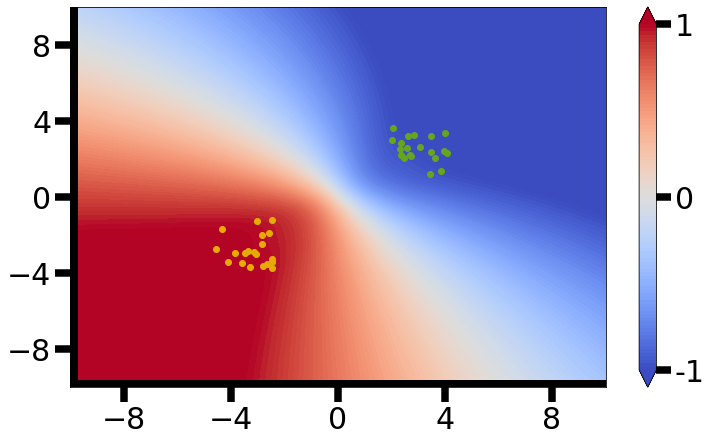

Working on **ana_relu_2l** ...

Accuracy on training points: 100.00%


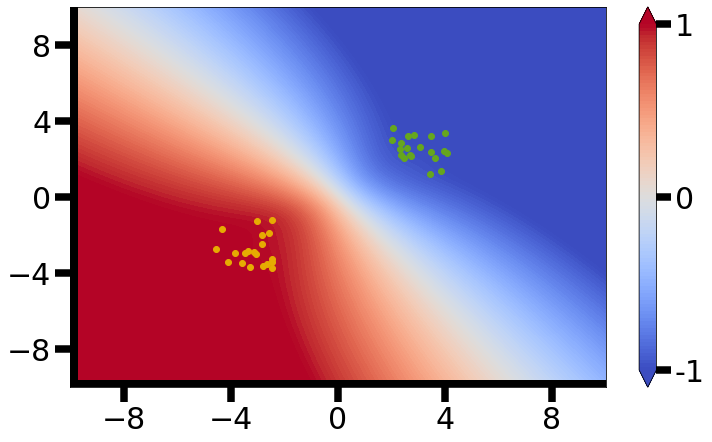

Working on **ana_erf_1l** ...

Accuracy on training points: 100.00%


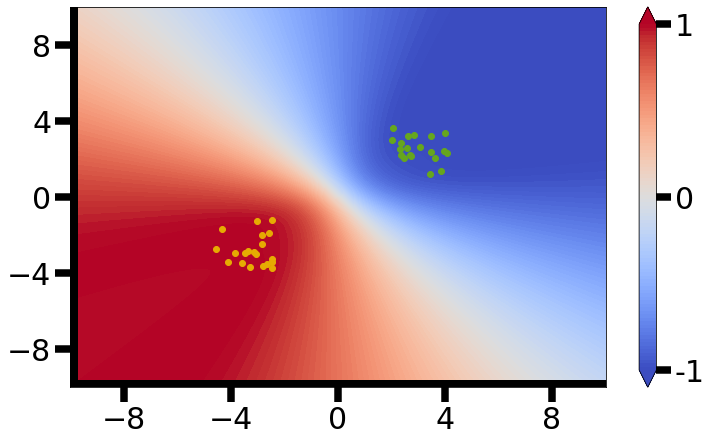

Working on **ana_erf_2l** ...

Accuracy on training points: 100.00%


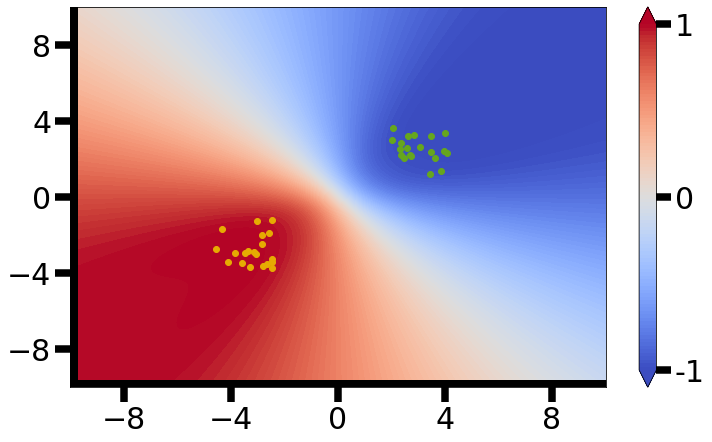

Working on **sigmoid_1l** ...

/home/christian/workspace/uncertainty-based-ood/nngp/nngp.py:162: UserWarning: Some entries of the covariance matrix are negative and set to 1e-5!
  warn('Some entries of the covariance matrix are negative and set to ' +


Accuracy on training points: 100.00%


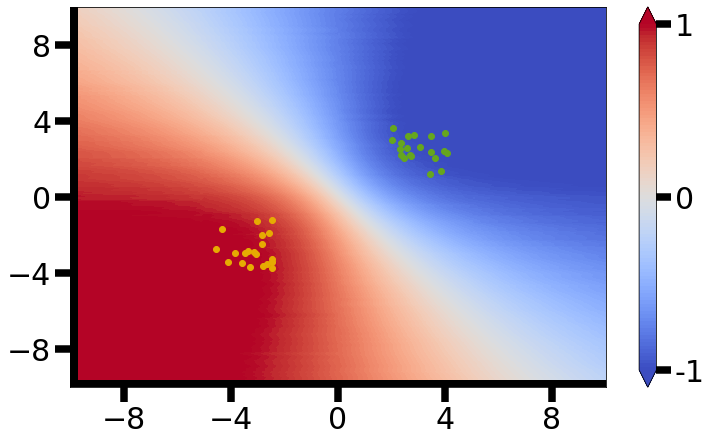

Working on **sigmoid_2l** ...

/home/christian/workspace/uncertainty-based-ood/nngp/nngp.py:162: UserWarning: Some entries of the covariance matrix are negative and set to 1e-5!
  warn('Some entries of the covariance matrix are negative and set to ' +


Accuracy on training points: 100.00%


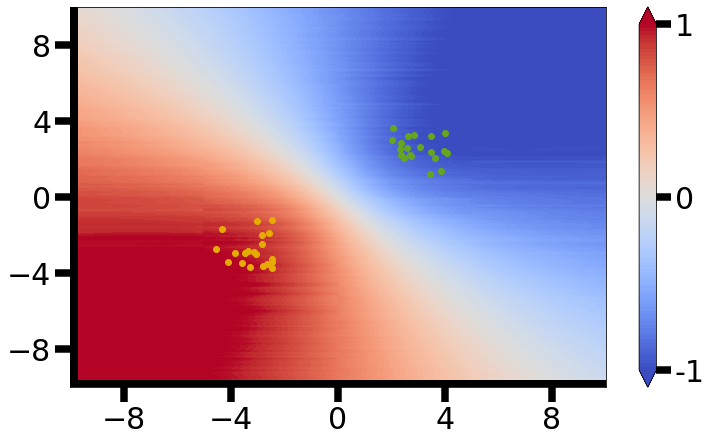

Working on **tanh_1l** ...

Accuracy on training points: 100.00%


/home/christian/workspace/uncertainty-based-ood/nngp/nngp.py:162: UserWarning: Some entries of the covariance matrix are negative and set to 1e-5!
  warn('Some entries of the covariance matrix are negative and set to ' +


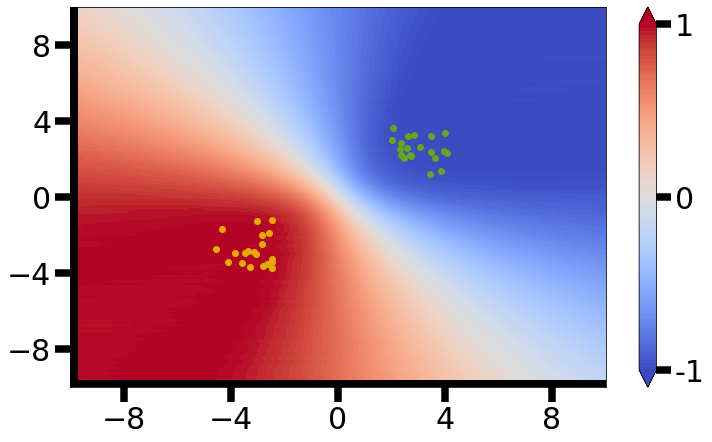

Working on **tanh_2l** ...

Accuracy on training points: 100.00%


/home/christian/workspace/uncertainty-based-ood/nngp/nngp.py:162: UserWarning: Some entries of the covariance matrix are negative and set to 1e-5!
  warn('Some entries of the covariance matrix are negative and set to ' +


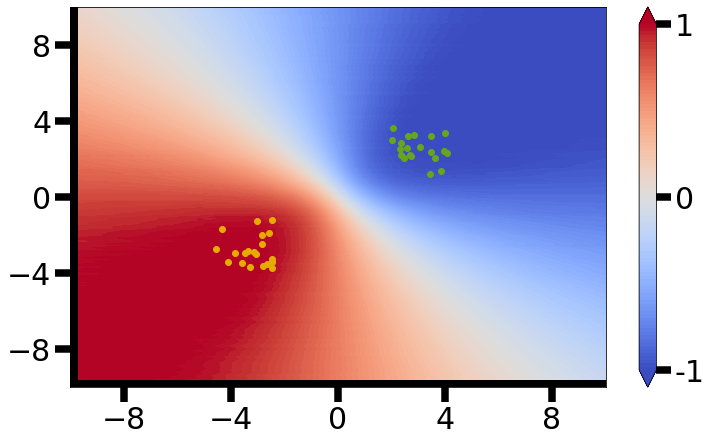

Working on **ana_cos_1l** ...

Accuracy on training points: 100.00%


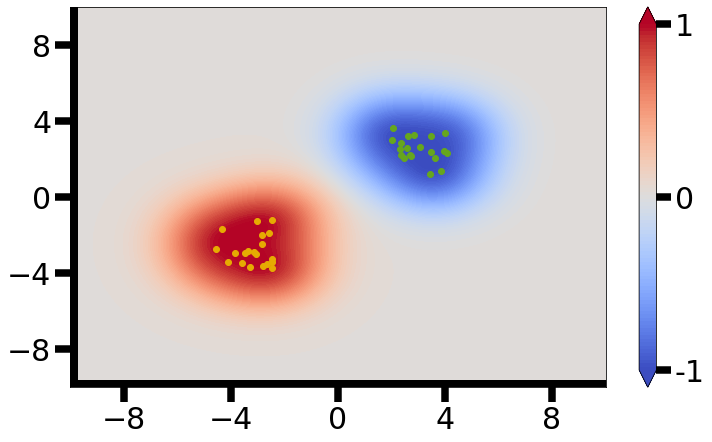

In [16]:
display(Markdown('All models use the likelihood **%f** ...' % (likelihood_var))) 

for i, k_props in enumerate(nngp_kernel_properties):
    if '4l' in k_props['name'] or '8l' in k_props['name']:
        continue
        
    if ('erf' in k_props['name'] or 'relu' in k_props['name']) and \
            not 'ana' in k_props['name']:
        continue
    
    display(Markdown('Working on **%s** ...' % (k_props['name']))) 
    
    if 'K_train' not in k_props.keys():
        continue
    
    K_train = k_props['K_train']
    K_test = k_props['K_test']
    K_all = k_props['K_all']

    try:
        train_mean, train_var = inference_with_isotropic_gaussian_ll( \
            Y_train, K_train, torch.diagonal(K_train), K_train, \
            var=likelihood_var)
        print('Accuracy on training points: %.2f%%' \
              % calc_regression_acc(train_mean, Y_train))
    except:
        display(Markdown('**WARN** Could not compute training accuracy for **%s**.' \
                         % (ll_var, k_props['name'])))
    
    try:
        grid_mean, grid_var = inference_with_isotropic_gaussian_ll( \
            Y_train, K_train, K_test, K_all, var=likelihood_var)
    except:
        L, ll_var = cholesky_adaptive_noise(K_train, var=likelihood_var, var_step=1.1)
        display(Markdown('**WARN** Have to use higher ll variance %f for **%s**.' \
                         % (ll_var, k_props['name'])))
        grid_mean, grid_var = inference_with_isotropic_gaussian_ll( \
            Y_train, K_train, K_test, K_all, L_mat=L, var=ll_var)
    
    if torch.any(torch.isnan(grid_mean)):
        nan_mask = torch.isnan(grid_mean)
        display(Markdown('**%d NaN values in predictive mean.**' \
                % nan_mask.sum()))
        grid_mean[nan_mask] = 0
    
    heatmap(grid_mean, title='Posterior Predictive Mean - %s' % (k_props['name']),
                vmin=-1, vmax=1, force_extend='both', cticks=[-1, 0, 1], 
                ctick_lbls=['-1', '0', '1'], filename='post_mean_%s' % k_props['name'],
                **heatmap_kwargs)        


# The standard deviation of the predictive posterior

Working on **ana_relu_1l** ...

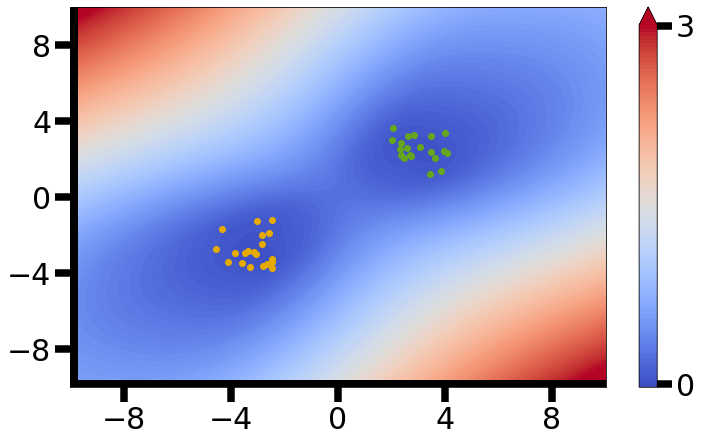

Working on **ana_relu_2l** ...

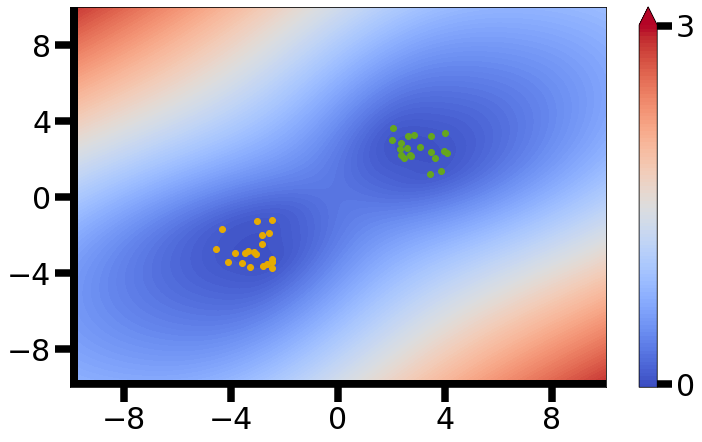

Working on **ana_erf_1l** ...

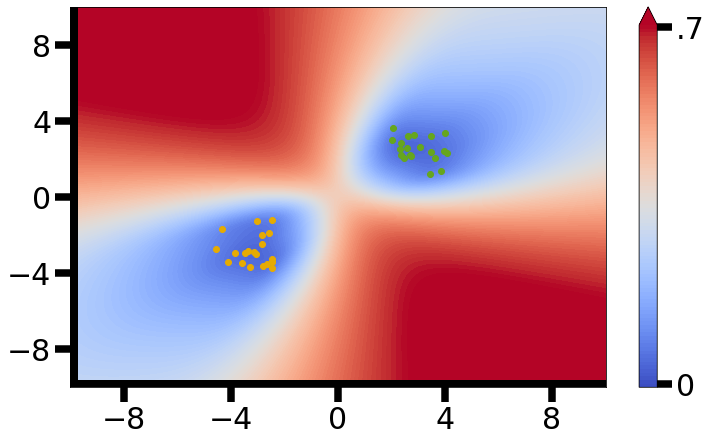

Working on **ana_erf_2l** ...

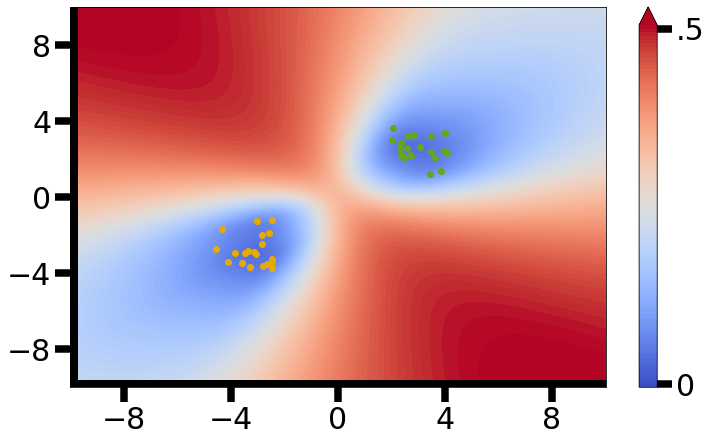

Working on **sigmoid_1l** ...

/home/christian/workspace/uncertainty-based-ood/nngp/nngp.py:162: UserWarning: Some entries of the covariance matrix are negative and set to 1e-5!
  warn('Some entries of the covariance matrix are negative and set to ' +


Working on **sigmoid_2l** ...

Working on **tanh_1l** ...

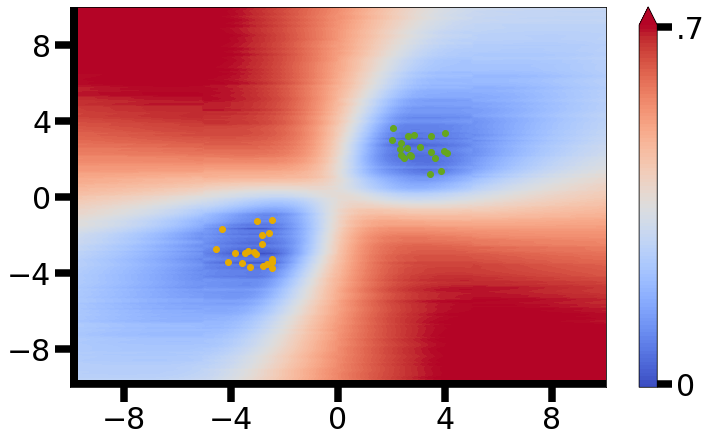

Working on **tanh_2l** ...

/home/christian/workspace/uncertainty-based-ood/nngp/nngp.py:162: UserWarning: Some entries of the covariance matrix are negative and set to 1e-5!
  warn('Some entries of the covariance matrix are negative and set to ' +


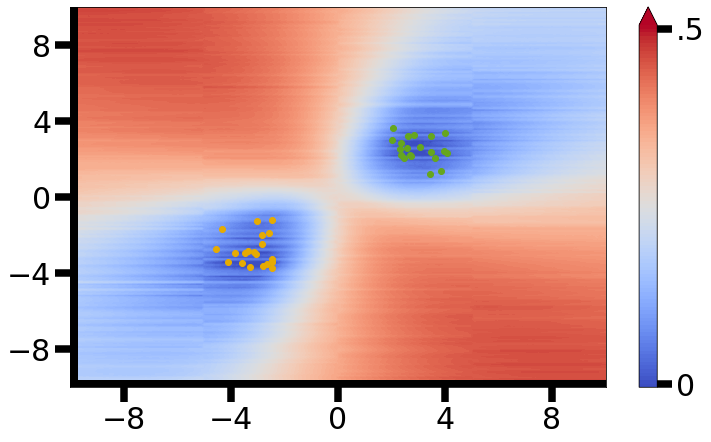

Working on **ana_cos_1l** ...

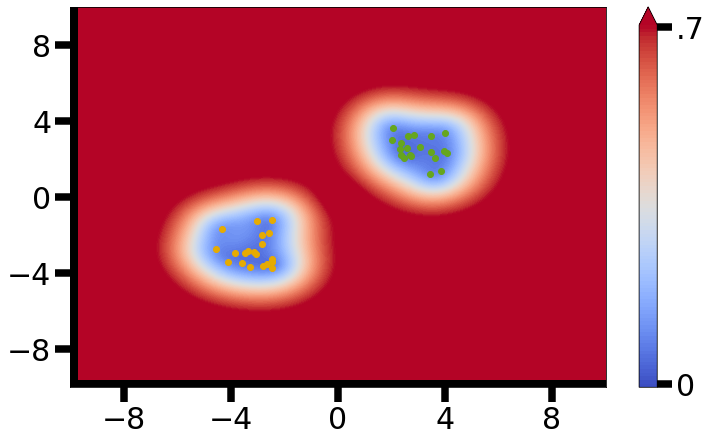

In [17]:
for i, k_props in enumerate(nngp_kernel_properties):
    if '4l' in k_props['name'] or '8l' in k_props['name']:
        continue
        
    if ('erf' in k_props['name'] or 'relu' in k_props['name']) and \
            not 'ana' in k_props['name']:
        continue
    
    display(Markdown('Working on **%s** ...' % (k_props['name']))) 
    
    if 'K_train' not in k_props.keys():
        continue
    
    K_train = k_props['K_train']
    K_test = k_props['K_test']
    K_all = k_props['K_all']
    
    try:
        grid_mean, grid_var = inference_with_isotropic_gaussian_ll( \
            Y_train, K_train, K_test, K_all, var=likelihood_var)
    except:
        L, ll_var = cholesky_adaptive_noise(K_train, var=likelihood_var, var_step=1.1)
        display(Markdown('**WARN** Have to use higher ll variance %f for **%s**.' \
                         % (ll_var, k_props['name'])))
        grid_mean, grid_var = inference_with_isotropic_gaussian_ll( \
            Y_train, K_train, K_test, K_all, L_mat=L, var=ll_var)
    
    grid_std = torch.sqrt(grid_var.cpu())
    #heatmap(grid_std, 'Posterior Predictive Std - %s' % (k_props['name']))
    if 'relu' in k_props['name']:
        heatmap(grid_std, title='Posterior Predictive Std - %s' % (k_props['name']),
                vmin=0, vmax=3, force_extend='max', cticks=[.025, 2.995],
                ctick_lbls=['0', '3'], filename='post_std_%s' % k_props['name'],
                **heatmap_kwargs)
    if 'erf_1l' in k_props['name'] or 'tanh_1l' in k_props['name']:
        heatmap(grid_std, title='Posterior Predictive Std - %s' % (k_props['name']),
                vmin=0, vmax=.7, force_extend='max', cticks=[.006, .695],
                ctick_lbls=['0', '.7'], filename='post_std_%s' % k_props['name'],
                **heatmap_kwargs)
    if 'erf_2l' in k_props['name'] or 'tanh_2l' in k_props['name']:
        heatmap(grid_std, title='Posterior Predictive Std - %s' % (k_props['name']),
                vmin=0, vmax=.5, force_extend='max', cticks=[.005, .495],
                ctick_lbls=['0', '.5'], filename='post_std_%s' % k_props['name'],
                **heatmap_kwargs)
    if 'cos' in k_props['name']:
        heatmap(grid_std, title='Posterior Predictive Std - %s' % (k_props['name']),
                vmin=0, vmax=.7, force_extend='max', cticks=[.006, .695],
                ctick_lbls=['0', '.7'], filename='post_std_%s' % k_props['name'],
                **heatmap_kwargs)

# The standard deviation of the prior predictive distribution

Working on **ana_relu_1l** ...

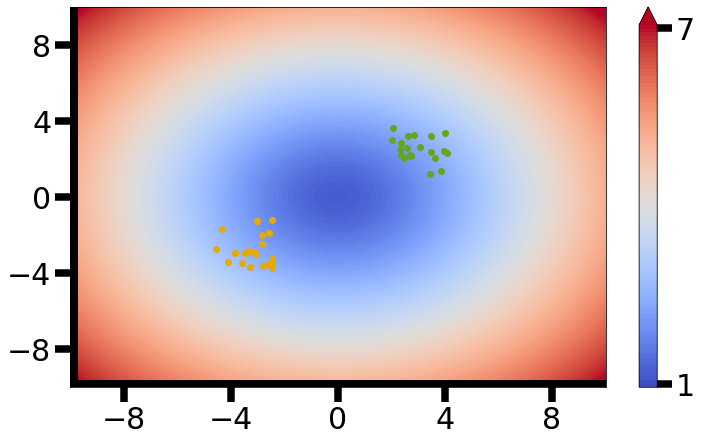

Working on **ana_relu_2l** ...

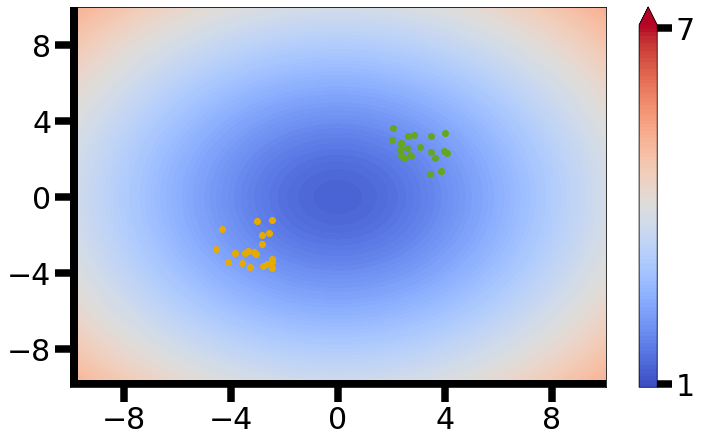

Working on **ana_erf_1l** ...

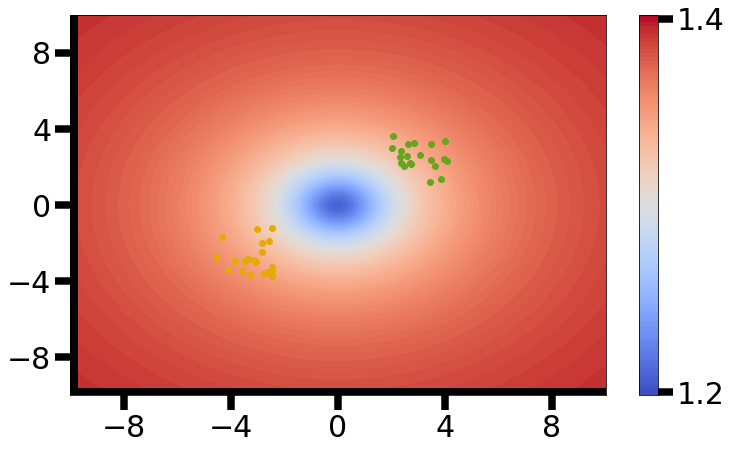

Working on **ana_erf_2l** ...

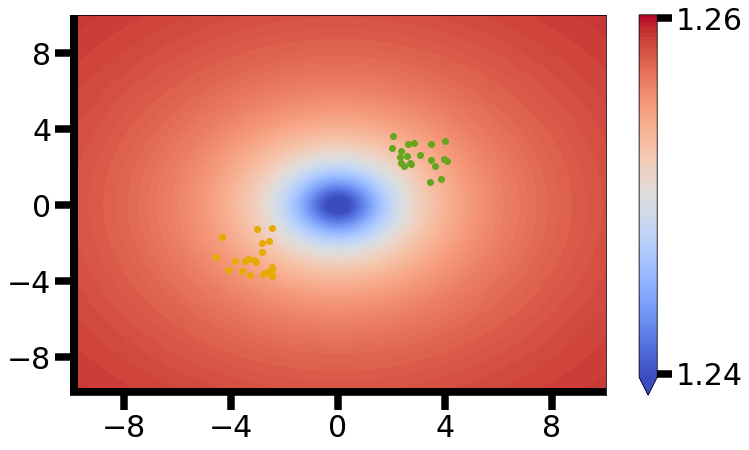

Working on **sigmoid_1l** ...

Working on **sigmoid_2l** ...

Working on **tanh_1l** ...

Working on **tanh_2l** ...

Working on **ana_cos_1l** ...

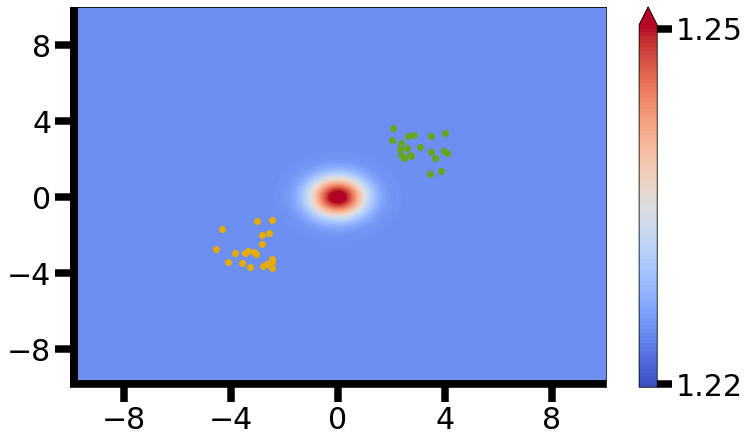

In [18]:
for i, k_props in enumerate(nngp_kernel_properties):
    if '4l' in k_props['name'] or '8l' in k_props['name']:
        continue
    
    if ('erf' in k_props['name'] or 'relu' in k_props['name']) and \
            not 'ana' in k_props['name']:
        continue
    
    display(Markdown('Working on **%s** ...' % (k_props['name']))) 
    
    if 'K_train' not in k_props.keys():
        continue
    
    K_train = k_props['K_train']
    K_test = k_props['K_test']
    K_all = k_props['K_all']
    
    grid_prior_std = torch.sqrt(K_test.cpu())
    #heatmap(grid_prior_std, 'Prior Predictive Std - %s' % (k_props['name']))
    if 'relu' in k_props['name']:
        heatmap(grid_prior_std, title='Prior Predictive Std - %s' % (k_props['name']),
                vmin=1, vmax=7, force_extend='max', cticks=[1.05, 6.95],
                ctick_lbls=['1', '7'], filename='prior_std_%s' % k_props['name'],
                **heatmap_kwargs)
    if 'erf_1l' in k_props['name']:
        heatmap(grid_prior_std, title='Prior Predictive Std - %s' % (k_props['name']),
                vmin=1.2, vmax=1.4, force_extend=None, cticks=[1.2+0.0015, 1.4-0.002],
                ctick_lbls=['1.2', '1.4'], filename='prior_std_%s' % k_props['name'],
                **heatmap_kwargs)
    if 'erf_2l' in k_props['name']:
        heatmap(grid_prior_std, title='Prior Predictive Std - %s' % (k_props['name']),
                vmin=1.24, vmax=1.26, force_extend='min', cticks=[1.24+0.0002, 1.26-0.0002],
                ctick_lbls=['1.24', '1.26'], filename='prior_std_%s' % k_props['name'],
                **heatmap_kwargs)
    if 'cos' in k_props['name']:
        heatmap(grid_prior_std, title='Prior Predictive Std - %s' % (k_props['name']),
                vmin=1.22, vmax=1.25, force_extend='max', cticks=[1.22+0.0003, 1.25-0.0003],
                ctick_lbls=['1.22', '1.25'], filename='prior_std_%s' % k_props['name'],
                **heatmap_kwargs)

In [19]:
writer.close()